In [1]:
import lomap
import networkx as nx

import os, sys, glob, subprocess
import math
import numpy as np
import matplotlib.pyplot as plt

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Recap,BRICS
from rdkit import DataStructs
from rdkit import RDLogger
from rdkit.Chem import rdMolAlign

p = AllChem.ETKDGv2()
p.verbose = False

import openfe
from openfe import SmallMoleculeComponent

Limitations:
1. Charged perturbations
2. Fused ring breaking or size changing example systems(ERa,)
3. 

In [2]:
## load all the sdf files and generate lomap network

db_mol = lomap.DBMolecules(".", output=True, name='era')
strict, loose = db_mol.build_matrices()
nx_graph = db_mol.build_graph()

In [3]:
## get edges whose score is less than cutoff
lomap_cutoff = 0.4

for_frag = []
for_frag.clear()
for edge in nx_graph.edges(data=True):
    score = nx_graph.edges[[edge[0], edge[1]]]['similarity']
    if score > lomap_cutoff:
        print('transformation: ' + str(nx_graph.nodes[edge[0]]['fname_comp']) + ' <--> ' + str(nx_graph.nodes[edge[1]]['fname_comp']))
    else:
        for_frag.append(nx_graph.nodes[edge[0]]['fname_comp'])
        for_frag.append(nx_graph.nodes[edge[1]]['fname_comp'])
        #print('Fragmentation required: ' + str(nx_graph.nodes[edge[0]]['fname_comp']) + ' <--> ' + str(nx_graph.nodes[edge[1]]['fname_comp']))


transformation: era_2d.sdf <--> era_2e.sdf


In [4]:
## generate a directory to store fragments:
os.makedirs('frags', exist_ok=True)

## get unique molecules from edges which have low lomap scores
molecules = []
molecules.clear()
for m in range(len(list(set(for_frag)))):
    tmp = Chem.SDMolSupplier(list(set(for_frag))[m], removeHs=False)
    smi = Chem.MolToSmiles(tmp[0])
    mol = Chem.MolFromSmiles(smi)
    molecules.append(mol)

In [5]:
## 2. ------------------------------------------
# generate dummy atom
du = Chem.MolFromSmiles('*')

all_smiles = []
all_smiles.clear()

##************************
## suppress rdkit warnings
RDLogger.DisableLog('rdApp.*')
##************************

## fragmenting using BRICSDecompose
for mol in molecules:
    frags = list(Chem.BRICS.BRICSDecompose(mol, minFragmentSize=1, keepNonLeafNodes=True, returnMols=False))
    ##if returnMols = False
    mols = [Chem.MolFromSmiles(x) for x in frags]
    ## replace dummy atoms with hydrogens
    molh = [AllChem.ReplaceSubstructs(x,du,Chem.MolFromSmiles('[H]'), True)[0] for x in mols]
    ## convert mols to smiles
    all_smiles.append([Chem.MolToSmiles(x) for x in molh])


##***************************
## enable default rdkit warnings again
RDLogger.EnableLog('rdApp.info')
##****************************


In [6]:
## 3. -----------------------------------------------------

## save fragments using similarity as a filter
## tanimoto similarity cut-off  = 0.35
## Dice threshold = 0.45
## the cut-offs are somewhat arbitrary for now.
x = 1
y = 1

fps = [] ## to filter duplicate fragments
fps.clear()

cutoff = 0.30
##  all_smiles is a list of list so, need to use a nested loop
for i in all_smiles:
    ref   = molecules[all_smiles.index(i)] ## similarity wrt reference parent molecule
    fp_r  = Chem.RDKFingerprint(ref)
    #fps.append(fp_r)
    for smi in i:
        mol   = Chem.MolFromSmiles(smi)
        query = mol
        mol   = Chem.AddHs(mol)        
        fp_q  = Chem.RDKFingerprint(query)
        sim   = DataStructs.TanimotoSimilarity(fp_r,fp_q)
        #print(f'similarity = {sim}, reference sdf index = {all_smiles.index(i)}')
        #print('========')
        if cutoff < round(sim,1) < 0.9: ## it means it's a fragment
            ## check whether we have a similar fragment from another parent
            frag_fps = []
            frag_fps.clear()
            for fp in range(len(fps)):
                frag_fps.append(DataStructs.TanimotoSimilarity(fps[fp], fp_q))
            if any(z==1 for z in frag_fps):
                x+=0
            else:
                fps.append(fp_q)
                ## save fragment molecules             
                with Chem.SDWriter('frags/tmp_' + str(y) + '_' +str(x) + '.sdf') as writer:
                    mol.SetProp('ID', 'tmp_' + str(y) + '_' + str(x))
                    confIds = Chem.AllChem.EmbedMultipleConfs(mol, 1)
                    for confId in range(1):
                        Chem.AllChem.UFFOptimizeMolecule(mol, confId=confId)
                        writer.write(mol, confId=confId)
                        x += 1
        else:
            x += 0
    y +=1
    x = 1


In [7]:
## generate and align 3D structures of the edges with good lomap scores

##***************************************
## open a reference sturcture upon which others will be aligned
## preserving input coordinates (must be 3D structure data file)
ref1 = Chem.SDMolSupplier('era_3b.sdf', removeHs=False)
for ref in ref1:
    #ref1_smi = Chem.MolToSmiles(ref)
    #ref1_mol = Chem.MolFromSmiles(ref1_smi)
    ref1_molh = ref #Chem.AddHs(ref1_mol)

AllChem.EmbedMultipleConfs(ref1_molh, 1)

## get MMFF parameters for the reference molecule
mmff_ref_param = AllChem.MMFFGetMoleculeProperties(ref1_molh)
ref_mol2 = ref1_molh
##*************************************

In [26]:
## RMSD function::

'''
https://github.com/DrrDom/rdkit-scripts/blob/master/rmsd_rdkit.py
'''

from rdkit.Chem import rdFMCS

def get_coord(mol, indices=None):
    if indices is None:
        indices = tuple(range(mol.GetNumAtoms()))
    output = []
    for atom_id in indices:
        pos = mol.GetConformer().GetAtomPosition(atom_id)
        output.append((pos.x, pos.y, pos.z))
    return tuple(output)



def rmsd(mol, ref, chirality):

    def rmsd_calc(r_coord, m_coord):
        s = 0
        for r, m in zip(r_coord, m_coord):
            s += (r[0] - m[0]) ** 2 + (r[1] - m[1]) ** 2 + (r[2] - m[2]) ** 2
        s = (s / len(r_coord)) ** 0.5
        return s

    match_indices = mol.GetSubstructMatches(ref, uniquify=False, useChirality=chirality, maxMatches=10000)
    min_rmsd = float('inf')
    if not match_indices:
        mcs = rdFMCS.FindMCS([mol, ref], threshold=1.0,
                             ringMatchesRingOnly=False, completeRingsOnly=False,
                             matchChiralTag=chirality)
        if not mcs:
            return None
        patt = Chem.MolFromSmarts(mcs.smartsString)
        refMatch, molMatch = ref.GetSubstructMatches(patt, uniquify=False), \
                             mol.GetSubstructMatches(patt, uniquify=False)

        for ids_ref in refMatch:
            for ids_mol in molMatch:
                ref_coord = get_coord(ref, ids_ref)
                mol_coord = get_coord(mol, ids_mol)
                s = rmsd_calc(ref_coord, mol_coord)
                if s < min_rmsd:
                    min_rmsd = s
    else:
        ref_coord = get_coord(ref)
        for ids in match_indices:
            mol_coord = get_coord(mol, ids)
            s = rmsd_calc(ref_coord, mol_coord)
            if s < min_rmsd:
                min_rmsd = s

    return round(min_rmsd, 3)

In [35]:
## LOMAP edges ====>>
os.makedirs('fromLomap', exist_ok=True)

for edge in nx_graph.edges(data=True):
    score = nx_graph.edges[[edge[0], edge[1]]]['similarity']
    if score > lomap_cutoff:
        print('transformation: ' + str(nx_graph.nodes[edge[0]]['fname_comp']) + ' <--> ' + str(nx_graph.nodes[edge[1]]['fname_comp']))
        
        mol1 = Chem.SDMolSupplier(str(nx_graph.nodes[edge[0]]['fname_comp']), removeHs=False)
        mol2 = Chem.SDMolSupplier(str(nx_graph.nodes[edge[1]]['fname_comp']), removeHs=False)
        
        sdfs = [mol1, mol2]
        molecules = []
        molecules.clear()
        for sdf in sdfs:
            smi = [Chem.MolToSmiles(x) for x in sdf]
            mol = [Chem.MolFromSmiles(x) for x in smi]
            molecules.append(Chem.AddHs(mol[0]))

        confs = 100 ## number of conformers to generate
        print(f'Generating {confs} conformers for each molecule')
        for mol in molecules[0:]:
            AllChem.EmbedMultipleConfs(mol, confs, p)

        ## get MMFF parameters for each molecule
        mmff_params = [AllChem.MMFFGetMoleculeProperties(mol) for mol in molecules]
        #mmff_ref_param = mmff_params[0]
        mmff_prob_params = mmff_params[0:]
        #ref_mol2 = molecules[0]
        prob_mols_2 = molecules[0:]


        ## perform alignment and save the best scored conformer
        print('Performing alignment and saving the conformer with best score only.')

        with Chem.SDWriter('fromLomap/' +str(nx_graph.nodes[edge[0]]['fname_comp']) +'_' + str(nx_graph.nodes[edge[1]]['fname_comp'])) as writer:
             #writer.write(ref_mol2)
            pyO3A_score = []
            rmsd = []
            for idx, mol in enumerate(prob_mols_2):
                tempscore = []
                temprmsd = []
                for cid in range(confs):
                    pyO3A = rdMolAlign.GetO3A(mol, ref_mol2, mmff_prob_params[idx], mmff_ref_param, cid, 0)
                    temprmsd.append(pyO3A.Align())
                    tempscore.append(pyO3A.Score())
                best = np.argmax(tempscore)
                rmsd.append(temprmsd[best])
                ## save sdf file
                ## write names, to be used with network in openFE
                mol.SetProp('_Name', str(nx_graph.nodes[edge[prob_mols_2.index(mol)]]['fname_comp']))
                mol.SetProp('ID', str(int(best)))
                writer.write(mol, confId=int(best))
                pyO3A_score.append(tempscore[best])
                
                #print(rmsd(mol, ref_mol2, True))
        print(f'rmsd: {rmsd}')  
        print('pyO3A_score: ' + str(pyO3A_score))
        print('===================================')

print('Finished LOMAP edges. Next step OpenFE')

transformation: era_2d.sdf <--> era_2e.sdf
Generating 100 conformers for each molecule
Performing alignment and saving the conformer with best score only.
rmsd: [0.25506281648689405, 0.17605480022634418]
pyO3A_score: [167.51714108508887, 161.08395010882523]
Finished LOMAP edges. Next step OpenFE


In [9]:
## openFE requires 3D sdf files and also they need to be aligned
## align fragments and their parent molecules to the same reference and save one sdf file

os.makedirs('forOpenfe', exist_ok=True)

file_names = []
sdfs = []
sdfs.clear()
for edge in nx_graph.edges(data=True):
    score = nx_graph.edges[[edge[0], edge[1]]]['similarity']
    if score < lomap_cutoff:
        print('poor edge: ' + str(nx_graph.nodes[edge[0]]['fname_comp']) + ' <--> ' + str(nx_graph.nodes[edge[1]]['fname_comp']))
        
        for i in range(2):  ## the length of an edge is 2.
            if str(nx_graph.nodes[edge[i]]['fname_comp']) not in file_names[0:]:
                file_names.append(str(nx_graph.nodes[edge[i]]['fname_comp']))
                sdfs.append(Chem.SDMolSupplier(str(nx_graph.nodes[edge[i]]['fname_comp']), removeHs=False))


for f in glob.glob("frags/*.sdf"):
    sdf = Chem.SDMolSupplier(f, removeHs=False)
    sdfs.append(sdf)
    file_names.append(str(f[6:]))

print(file_names)
print(f'------------------------------')

molecules = []
molecules.clear()
for sdf in sdfs:
    smi = [Chem.MolToSmiles(x) for x in sdf]
    mol = [Chem.MolFromSmiles(x) for x in smi]
    molecules.append(Chem.AddHs(mol[0]))

confs = 100 ## number of conformers to generate
print(f'Generating {confs} conformers for each molecule')
for mol in molecules[0:]:
    AllChem.EmbedMultipleConfs(mol, confs, p)

## get MMFF parameters for each molecule
mmff_params = [AllChem.MMFFGetMoleculeProperties(mol) for mol in molecules]
#mmff_ref_param = mmff_params[0]
mmff_prob_params = mmff_params[0:]
#ref_mol2 = molecules[0]
prob_mols_2 = molecules[0:]


## perform alignment and save the best scored conformer
print('Performing alignment and saving the conformer with best score only.')

#with Chem.SDWriter(f'forOpenfe/.sdf') as writer:
    #writer.write(ref_mol2)

pyO3A_score = []
for idx, mol in enumerate(prob_mols_2):   
    tempscore = []
    for cid in range(confs):
        pyO3A = rdMolAlign.GetO3A(mol, ref_mol2, mmff_prob_params[idx], mmff_ref_param, cid, 0)
        pyO3A.Align()
        tempscore.append(pyO3A.Score())
    best = np.argmax(tempscore)
    ## save sdf file
    print(f'writing sdf file: {file_names[prob_mols_2.index(mol)]}')
    with Chem.SDWriter(f'forOpenfe/{file_names[prob_mols_2.index(mol)]}') as writer:
        ## write names, to be used with network in openFE
        mol.SetProp('_Name', str(file_names[prob_mols_2.index(mol)]))
        mol.SetProp('ID', str(int(best)))
        writer.write(mol, confId=int(best))
    
    pyO3A_score.append(tempscore[best])
    #print('pyO3A_score: ' + str(pyO3A_score))

print('Finished with aligned file, go to OpenFE for network generation.')
        

poor edge: era_2d.sdf <--> era_3b.sdf
poor edge: era_2e.sdf <--> era_3b.sdf
['era_2d.sdf', 'era_3b.sdf', 'era_2e.sdf', 'tmp_1_1.sdf', 'tmp_2_1.sdf', 'tmp_2_2.sdf', 'tmp_3_1.sdf']
------------------------------
Generating 100 conformers for each molecule
Performing alignment and saving the conformer with best score only.
writing sdf file: era_2d.sdf
writing sdf file: era_3b.sdf
writing sdf file: era_2e.sdf
writing sdf file: tmp_1_1.sdf
writing sdf file: tmp_2_1.sdf
writing sdf file: tmp_2_2.sdf
writing sdf file: tmp_3_1.sdf
Finished with aligned file, go to OpenFE for network generation.


In [10]:
## openFE maximal_netwok

sdfs = []
for f in glob.glob('forOpenfe/*.sdf'):
    sdf = Chem.SDMolSupplier(f, removeHs=False)
    sdfs.append(sdf[0])

ligands = [SmallMoleculeComponent(sdf) for sdf in sdfs]

mapper = openfe.LomapAtomMapper(max3d=100.0, element_change=True)
scorer = openfe.lomap_scorers.default_lomap_score
network_planner = openfe.ligand_network_planning.generate_maximal_network


In [11]:
ligand_network = network_planner(
ligands=ligands[0:],
     mappers=[mapper],
     scorer=scorer
)

In [16]:
G = nx.Graph()

## low lomap score ==> considered as good edge weight by networkx or netowrkx edges are closer
## high lomap score ==> considered as bad edge weight by networkx or networkx edges are further 

for edge in ligand_network.edges:
    try:
        G.add_edge(edge.componentA.name, edge.componentB.name, weight=round(-math.log(edge.annotations['score']), 4), lomap_score=round(edge.annotations['score'], 4))
    except ValueError: ## if the edge score is zero, assign a high score (here randomly I chose 5)
        G.add_edge(edge.componentA.name, edge.componentB.name, weight=5, lomap_score=round(edge.annotations['score'], 4))

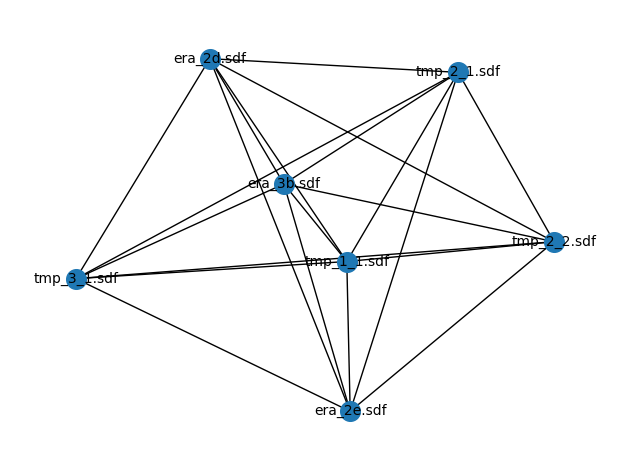

In [13]:
## plotting ------------------

pos = nx.spring_layout(G, seed=7)  # positions for all nodes - seed for reproducibility

## nodes
nx.draw_networkx_nodes(G, pos, node_size=200)

## edges
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=1)

## node labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

## edge weight labels
edge_labels = nx.get_edge_attributes(G, "weight")
#nx.draw_networkx_edge_labels(G, pos, edge_labels)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

In [14]:
parents = []
parents.clear()
for node in G.nodes():
    if node[0:3] != 'tmp':
        parents.append(node)

In [15]:
for edge in nx_graph.edges(data=True): ## from lomap network get poor edges
    score = nx_graph.edges[[edge[0], edge[1]]]['similarity']
    if score < lomap_cutoff:
        source = nx_graph.nodes[edge[0]]['fname_comp']
        target = nx_graph.nodes[edge[1]]['fname_comp']
        
        all_paths = list(nx.all_simple_paths(G, source=source, target=target, cutoff=3))
        
        score = []
        score.clear()
        final_path = []
        final_path.clear()
        for path in range(len(all_paths)):
            #print(all_paths[path])
            pathGraph = nx.path_graph(all_paths[path])
            final_path.append(pathGraph)
            weights = []
            weights.clear()
            for ea in pathGraph.edges():
                weights.append(G.edges[ea[0], ea[1]]['weight'])
            
            score.append(round(sum(weights) / pathGraph.number_of_edges()**2, 4))
            #print('final score: ' + str(round(sum(weights) / pathGraph.number_of_edges(), 4)))

        print(f'{source}, {target}, score: {min(score)}, {final_path[score.index(min(score))]}')
        
        for ea in final_path[score.index(min(score))].edges(data=True):
            if G.edges[ea[0], ea[1]]['lomap_score'] < 0.2:
                print(ea[0], '<-->', ea[1], '=> LOMAP score', G.edges[ea[0], ea[1]]['lomap_score'], '**poor edge**')
            else:
                print(ea[0], '<-->', ea[1], '=> LOMAP score', G.edges[ea[0], ea[1]]['lomap_score'])
            #file_write = 'cat forOpenfe/' + str(ea[0]) + ' forOpenfe/' + str(ea[1]) + ' > ' + str(ea[0]) + '_' + str(ea[1])
            #subprocess.check_call(file_write, shell=True)
        print('===================')
            

era_2d.sdf, era_3b.sdf, score: 0.5447, Graph with 4 nodes and 3 edges
era_2d.sdf <--> tmp_3_1.sdf => LOMAP score 0.3679
tmp_3_1.sdf <--> tmp_1_1.sdf => LOMAP score 0.0407 **poor edge**
tmp_1_1.sdf <--> era_3b.sdf => LOMAP score 0.4966
era_2e.sdf, era_3b.sdf, score: 0.5114, Graph with 4 nodes and 3 edges
era_2e.sdf <--> tmp_2_2.sdf => LOMAP score 0.4493
tmp_2_2.sdf <--> tmp_1_1.sdf => LOMAP score 0.0449 **poor edge**
tmp_1_1.sdf <--> era_3b.sdf => LOMAP score 0.4966


In [43]:
##------------Finished------------------------##
##------------old-trials----------------------##

In [ ]:
all_paths = list(nx.all_simple_paths(G, source=parents[3], target=parents[0], cutoff=3))
#all_paths

In [44]:
#nx.shortest_path(G, source=parents[0], target=parents[1])

In [55]:
score = []
score.clear()
final_path = []
final_path.clear()
for path in range(len(all_paths)):
    #print(all_paths[path])
    pathGraph = nx.path_graph(all_paths[path])
    final_path.append(pathGraph)
    weights = []
    weights.clear()
    for ea in pathGraph.edges():
        weights.append(G.edges[ea[0], ea[1]]['weight'])
    score.append(round(sum(weights) / pathGraph.number_of_edges()**2, 4))
    #print('final score: ' + str(round(sum(weights) / pathGraph.number_of_edges(), 4)))

#score.index(min(score))
print(f'{min(score)}, {final_path[score.index(min(score))]}')

0.3667, Graph with 4 nodes and 3 edges


In [56]:
final_path[score.index(min(score))].edges(data=True)

EdgeDataView([('mol_1a.sdf', 'tmp_1_1.sdf', {}), ('tmp_1_1.sdf', 'tmp_2_1.sdf', {}), ('tmp_2_1.sdf', 'mol_4a.sdf', {})])

In [57]:
for ea in final_path[score.index(min(score))].edges(data=True):
    print(ea[0], ea[1], G.edges[ea[0], ea[1]]['lomap_score'])
    file_write = 'cat forOpenfe/' + str(ea[0]) + ' forOpenfe/' + str(ea[1]) + ' > ' + str(ea[0]) + '_' + str(ea[1])
    subprocess.check_call(file_write, shell=True)
    

mol_1a.sdf tmp_1_1.sdf 0.4066
tmp_1_1.sdf tmp_2_1.sdf 0.2231
tmp_2_1.sdf mol_4a.sdf 0.4066
